In [3]:
import sdepy
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
import tensorflow as tf
import pandas as pd
import os
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
from tqdm import tqdm
from fbm import FBM

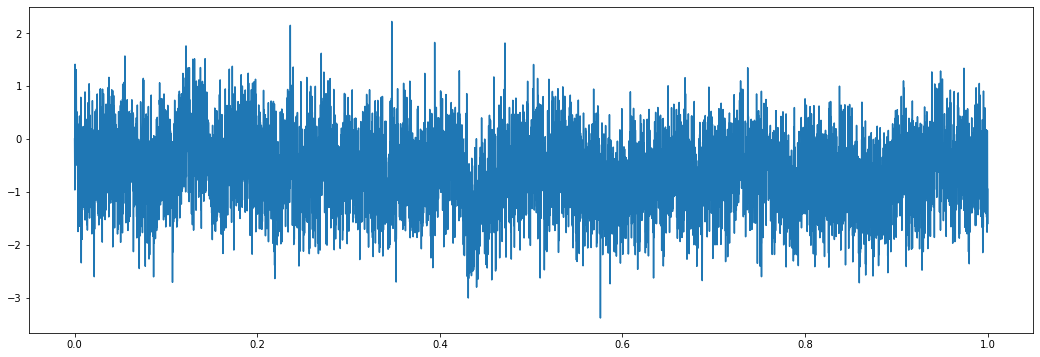

max:  0.6888841473743434 min:  -0.6452984844632871


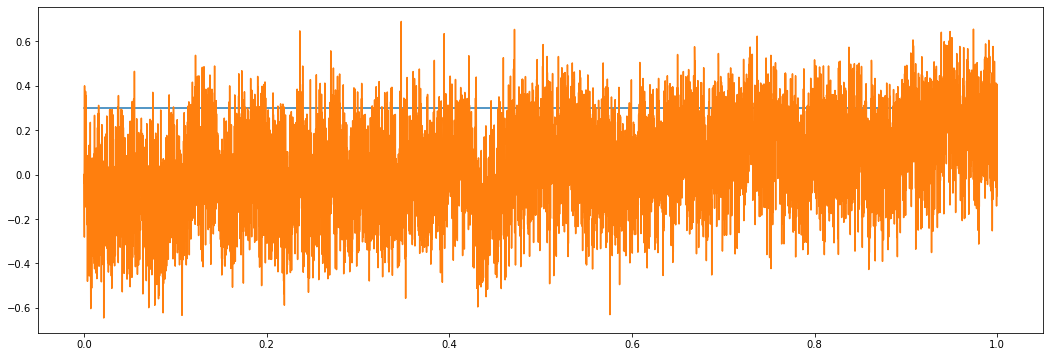

In [4]:
nlength = 10000
t = 1
dt = t / nlength
hurst = 0.02

times = np.linspace(start=0, stop=t, num=nlength) # numpy.ndarray (nlength,)
paths = 1

fbm = FBM(n=nlength-1, hurst=hurst, length=t, method='cholesky')
fbm_sample = fbm.fbm() # numpy.ndarray (nlength,

plt.figure(figsize=(18,6))
plt.plot(times, fbm_sample)
plt.show()

alpha = 1.5
mu = 0.3
sigma = 0.3

W = fbm_sample.reshape(nlength, 1)

sdepy_W = sdepy.process(t=times, x=W)

@sdepy.integrate
def X_process(t, x, alpha=1, mu=1, sigma=1):
    return {
        'dt': alpha*(mu - np.tanh(x)),
        'dw': sigma,
    }

X = X_process(paths=1, x0=0, alpha=alpha, mu=mu, sigma=sigma, dw=sdepy_W)(times)

print('max: ', np.tanh(X).max(), 'min: ', np.tanh(X).min())
plt.figure(figsize=(18,6))
plt.plot([0, 1], [mu, mu])
plt.plot(times, np.tanh(X))
plt.show()

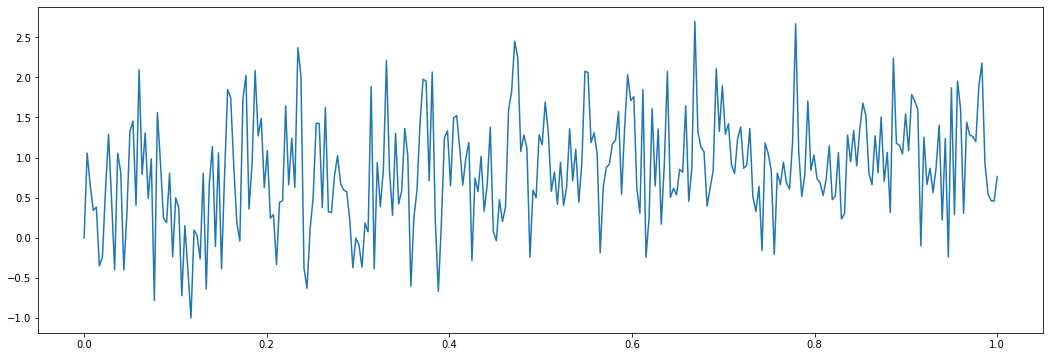

max:  0.38487006164500936 min:  -0.6510663932728832


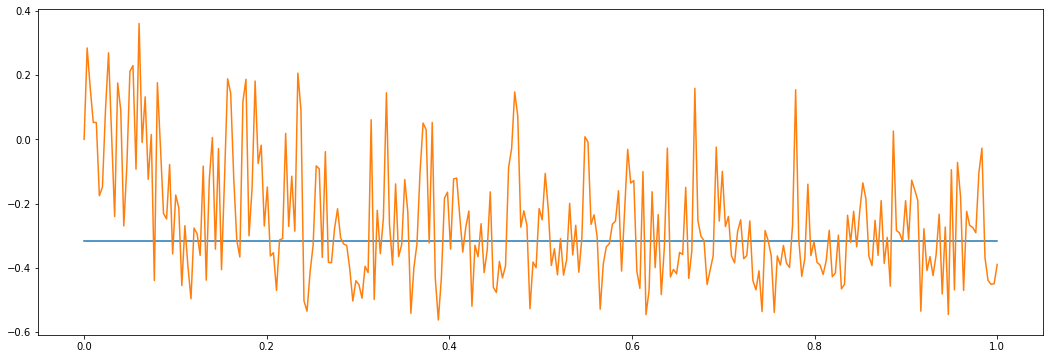

In [ ]:
nlength = 300
t = 1
dt = t / nlength
hurst = 0.02

times = np.linspace(start=0, stop=t, num=nlength) # numpy.ndarray (nlength,)
paths = 1

fbm = FBM(n=nlength-1, hurst=hurst, length=t, method='cholesky')
fbm_sample = fbm.fbm() # numpy.ndarray (nlength,

plt.figure(figsize=(18,6))
plt.plot(times, fbm_sample)
plt.show()

alpha = 10.5
mu = np.random.uniform(-0.5, 0.5)
sigma = 0.3

W = fbm_sample.reshape(nlength, 1)

sdepy_W = sdepy.process(t=times, x=W)

@sdepy.integrate
def X_process(t, x, alpha=1, mu=1, sigma=1):
    return {
        'dt': alpha*(mu - ((2 / np.pi) * np.arctan((np.pi / 2) * x))),
        'dw': sigma,
    }

X = X_process(paths=1, x0=0, alpha=alpha, mu=mu, sigma=sigma, dw=sdepy_W)(times)

print('max: ', np.tanh(X).max(), 'min: ', np.tanh(X).min())
plt.figure(figsize=(18,6))
plt.plot([0, 1], [mu, mu])
plt.plot(times, (2 / np.pi) * np.arctan((np.pi / 2) * X))
plt.show()

In [6]:
plt.style.use('seaborn-bright')
font = {'family': 'normal',
        'weight': 'normal',
        'size': 14}

plt.rc('font', **font)
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
print(tf.__version__)

# # clear keras backend
K.clear_session()

# create keras backend
keras.backend.set_floatx('float64')

# convolution model
# model = tf.keras.Sequential()
# model.add(tf.keras.Input(shape=(nlength-1, 1)))
# model.add(tf.keras.layers.Conv1D(filters=1, kernel_size=3, activation=tf.keras.activations.elu))
# model.add(tf.keras.layers.MaxPool1D(pool_size=3))
# model.add(tf.keras.layers.Flatten())
# model.add(tf.keras.layers.Dense(units=30, activation=tf.keras.activations.elu))
# model.add(tf.keras.layers.Dense(units=1, activation=tf.keras.activations.elu))
# model.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.mean_squared_error)

# sequential model
model = keras.Sequential([
    tf.keras.layers.Dense(30, activation=tf.keras.activations.elu, input_shape=(nlength-1,)),
    tf.keras.layers.Dense(30, activation=tf.keras.activations.elu),
    tf.keras.layers.Dense(1, activation=tf.keras.activations.elu),
])
model.summary()
model.compile(optimizer='adam', loss=tf.keras.losses.mean_squared_error)

# generate fbm example
simulated = []
test = []

for samples in tqdm(range(100)):
    fbm = FBM(n=nlength-1, hurst=hurst, length=t, method='cholesky')
    fbm_sample = fbm.fbm()

    W = fbm_sample.reshape(nlength, 1)
    alpha = 10
    mu = np.random.uniform(0, 1)
    sigma = np.random.uniform(0, (1-np.abs(mu) / 2))

    sdepy_W = sdepy.process(t=times, x=W)

    @sdepy.integrate
    def X_process(t, x, alpha=1, mu=1, sigma=1):
        return {
            'dt': alpha*(mu - np.tanh(x)),
            'dw': sigma,
        }

    X = X_process(paths=1, x0=0, alpha=alpha, mu=mu, sigma=sigma, dw=sdepy_W)(times)
    tanhX = np.tanh(X)
    x = np.transpose(pd.DataFrame(tanhX).values)
    xdiff = np.transpose(pd.DataFrame(tanhX).values[1:])
    
    for j in range(1, len(x)):
        xdiff[0, j-1] = X[j]-X[j-1]
    # for convolution model model
    # xx = np.array(xdiff.reshape(1, nlength-1, 1))
    # estimated = model.predict(xx)
    estimated = model.predict(xdiff)
    simulated.append(sigma)
    test.append(estimated[0][0])
    print('simulated: ', sigma, 'predicted: ', estimated)

  0%|          | 0/100 [00:00<?, ?it/s]2.4.1
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 30)                300000    
_________________________________________________________________
dense_1 (Dense)              (None, 30)                930       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 31        
Total params: 300,961
Trainable params: 300,961
Non-trainable params: 0
_________________________________________________________________
  1%|          | 1/100 [01:47<2:57:59, 107.87s/it]


KeyboardInterrupt: 

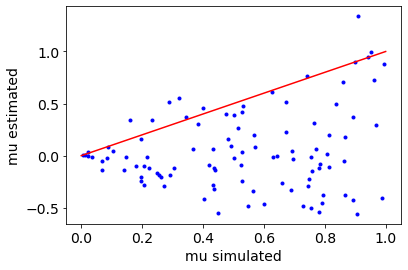

In [ ]:
plt.figure()
plt.plot(simulated, test, 'b.')
plt.plot([0, 1], [0, 1], 'r-')
plt.xlabel('mu simulated')
plt.ylabel('mu estimated')
plt.show()

Sigma becslés keras-sequential modellel.


In [ ]:
nlength = 3000
t = 1
dt = t / nlength
hurst = 0.02

times = np.linspace(start=0, stop=t, num=nlength) # numpy.ndarray (nlength,)
paths = 1
m = 1

# # clear keras backend
K.clear_session()

# create keras backend
keras.backend.set_floatx('float64')

model = keras.Sequential([
    # tf.keras.layers.Embedding(input_dim=nlength-1, output_dim=1),
    tf.keras.layers.Dense(30, activation='relu', input_shape=(nlength-1,)),
    tf.keras.layers.Dense(30, activation='relu'),
    tf.keras.layers.Dense(1, activation='relu'),
])
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

# generate fbm example
simulated = []
test = []

index = 0
append_index = 0

while len(test) != 100:
# for samples in tqdm(range(100)):
    index = index + 1
    fbm = FBM(n=nlength-1, hurst=hurst, length=t, method='cholesky')
    fbm_sample = fbm.fbm()

    W = fbm_sample.reshape(nlength, 1)
    alpha = 10
    mu = np.random.uniform(0, 1)
    sigma = np.random.uniform(0, 1-np.abs(mu))

    sdepy_W = sdepy.process(t=times, x=W)

    @sdepy.integrate
    def X_process(t, x, alpha=1, mu=1, sigma=1):
        return {
            'dt': alpha*(mu - np.tanh(x)),
            'dw': sigma,
        }

    X = X_process(paths=1, x0=0, alpha=alpha, mu=mu, sigma=sigma, dw=sdepy_W)(times)
    tanhX = np.tanh(X)
    x = np.transpose(pd.DataFrame(tanhX).values)
    xdiff = np.transpose(pd.DataFrame(tanhX).values[1:])

    for j in range(1, len(x)):
        xdiff[0, j-1] = tanhX[j]-tanhX[j-1]

    estimated = model.predict(xdiff)
    if np.linalg.norm(sigma-estimated[0][0]) < 0.1:
      simulated.append(sigma)
      test.append(estimated[0][0])
      append_index = append_index + 1
      print(f'appended: {append_index}')
    else:
      None
    print(f'index: {index-1}','simulated: ', sigma, 'predicted: ', estimated)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 30)                90000     
_________________________________________________________________
dense_1 (Dense)              (None, 30)                930       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 31        
Total params: 90,961
Trainable params: 90,961
Non-trainable params: 0
_________________________________________________________________
index: 0 simulated:  0.6815356394391889 predicted:  [[0.]]
index: 1 simulated:  0.14058507082337396 predicted:  [[0.03154941]]
appended: 1
index: 2 simulated:  0.016051410020399646 predicted:  [[0.03143748]]
index: 3 simulated:  0.43140232217079166 predicted:  [[0.]]
appended: 2
index: 4 simulated:  0.01639570029070175 predicted:  [[0.04050346]]
appended: 3
index: 5 simulated:  0

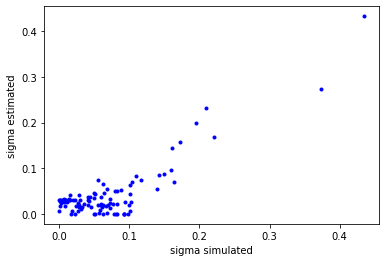

In [ ]:
plt.figure()
plt.plot(simulated, test, 'b.')
# plt.plot([0, 1], [0, 1], 'r-')
plt.xlabel('sigma simulated')
plt.ylabel('sigma estimated')
plt.show()

In [ ]:
# generate fbm example
simulated = []
test = []

index = 0
append_index = 0

while len(test) != 100:
# for samples in tqdm(range(100)):
    index = index + 1
    hurst = np.random.uniform(0.02, 0.05)
    fbm = FBM(n=nlength-1, hurst=hurst, length=t, method='cholesky')
    fbm_sample = fbm.fbm()

    W = fbm_sample.reshape(nlength, 1)
    alpha = 10
    mu = np.random.uniform(0, 1)
    sigma = np.random.uniform(0, 1-np.abs(mu))

    sdepy_W = sdepy.process(t=times, x=W)

    @sdepy.integrate
    def X_process(t, x, alpha=1, mu=1, sigma=1):
        return {
            'dt': alpha*(mu - np.tanh(x)),
            'dw': sigma,
        }

    X = X_process(paths=1, x0=0, alpha=alpha, mu=mu, sigma=sigma, dw=sdepy_W)(times)
    tanhX = np.tanh(X)
    x = np.transpose(pd.DataFrame(tanhX).values)
    xdiff = np.transpose(pd.DataFrame(tanhX).values[1:])

    for j in range(1, len(x)):
        xdiff[0, j-1] = tanhX[j]-tanhX[j-1]

    estimated = model.predict(xdiff)
    if np.linalg.norm(sigma-estimated[0][0]) < 0.1:
      simulated.append(sigma)
      test.append(estimated[0][0])
      append_index = append_index + 1
      print(f'appended: {append_index}')
    else:
      None
    print(f'index: {index-1}','simulated: ', sigma, 'predicted: ', estimated)

index: 0 simulated:  0.4715079814890277 predicted:  [[0.15005517]]
index: 1 simulated:  0.47161891560604774 predicted:  [[0.12402357]]
appended: 1
index: 2 simulated:  0.06655163215856001 predicted:  [[0.03440834]]
index: 3 simulated:  0.1446847315543301 predicted:  [[0.]]
appended: 2
index: 4 simulated:  0.008509584765704957 predicted:  [[0.00128129]]
appended: 3
index: 5 simulated:  0.008145350764233209 predicted:  [[0.03162584]]
index: 6 simulated:  0.2508190662330629 predicted:  [[0.06606046]]
appended: 4
index: 7 simulated:  0.03717194667299626 predicted:  [[0.02920787]]
index: 8 simulated:  0.8585070372504063 predicted:  [[0.0622083]]
index: 9 simulated:  0.2312634082418442 predicted:  [[0.04255294]]
index: 10 simulated:  0.1549777590094092 predicted:  [[0.]]
appended: 5
index: 11 simulated:  0.05433529788524714 predicted:  [[0.00963956]]
index: 12 simulated:  0.410364971888542 predicted:  [[0.]]
index: 13 simulated:  0.2869303046186197 predicted:  [[0.]]
appended: 6
index: 14 si

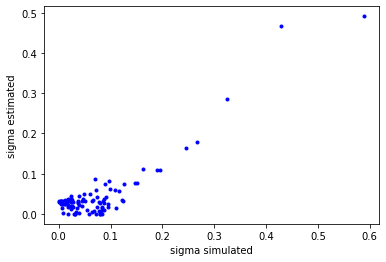

In [ ]:
plt.figure()
plt.plot(simulated, test, 'b.')
# plt.plot([0, 1], [0, 1], 'r-')
plt.xlabel('sigma simulated')
plt.ylabel('sigma estimated')
plt.show()

Mu becslés keras-sequential model.

In [ ]:
nlength = 20000
t = 1
dt = t / nlength
hurst = 0.02

times = np.linspace(start=0, stop=t, num=nlength) # numpy.ndarray (nlength,)
paths = 1
m = 1

# # clear keras backend
K.clear_session()

# create keras backend
keras.backend.set_floatx('float64')

model = keras.Sequential([
    # tf.keras.layers.Embedding(input_dim=nlength-1, output_dim=1),
    tf.keras.layers.Dense(30, activation='relu', input_shape=(nlength-1,)),
    tf.keras.layers.Dense(30, activation='relu'),
    tf.keras.layers.Dense(1, activation='relu'),
])
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

# model = keras.Sequential([
#     # tf.keras.layers.Embedding(input_dim=nlength-1, output_dim=1),
#     tf.keras.layers.Dense(12, activation='elu', input_shape=(nlength-1,), kernel_constraint=tf.keras.constraints.MinMaxNorm(min_value=0.02, max_value=0.05), kernel_regularizer=tf.keras.regularizers.l1_l2()),
#     tf.keras.layers.Dense(12, activation='elu', kernel_constraint=tf.keras.constraints.MinMaxNorm(min_value=0.02, max_value=0.05), kernel_regularizer=tf.keras.regularizers.l1_l2()),
#     tf.keras.layers.Dense(12, activation='elu', kernel_constraint=tf.keras.constraints.MinMaxNorm(min_value=0.02, max_value=0.05), kernel_regularizer=tf.keras.regularizers.l1_l2()),
#     tf.keras.layers.ELU(alpha=0.01),
#     tf.keras.layers.Dense(1, kernel_constraint=tf.keras.constraints.MinMaxNorm(min_value=0.02, max_value=0.05), kernel_regularizer=tf.keras.regularizers.l1_l2()),
# ])
# model.compile(optimizer='adam', loss=tf.keras.losses.mean_squared_error)
# model.summary()

# generate fbm example
simulated = []
test = []

index = 0
append_index = 0

while len(test) != 100:
# for samples in tqdm(range(100)):
    index = index + 1
    hurst = np.random.uniform(0.02, 0.05)
    fbm = FBM(n=nlength-1, hurst=hurst, length=t, method='cholesky')
    fbm_sample = fbm.fbm()

    W = fbm_sample.reshape(nlength, 1)
    alpha = 10
    mu = np.random.uniform(-0.5, 0.5)
    sigma = np.random.uniform(0, (1-np.abs(mu) / 2))

    sdepy_W = sdepy.process(t=times, x=W)

    @sdepy.integrate
    def X_process(t, x, alpha=1, mu=1, sigma=1):
        return {
            'dt': alpha*(mu - np.tanh(x)),
            'dw': sigma,
        }

    X = X_process(paths=1, x0=0, alpha=alpha, mu=mu, sigma=sigma, dw=sdepy_W)(times)
    tanhX = np.tanh(X)
    x = np.transpose(pd.DataFrame(tanhX).values)
    xdiff = np.transpose(pd.DataFrame(tanhX).values[1:])

    for j in range(1, len(x)):
        xdiff[0, j-1] = tanhX[j]-tanhX[j-1]

    estimated = model.predict(xdiff)
    # if np.linalg.norm(np.abs(hurst-estimated[0][0])) < 0.1:
    simulated.append(mu)
    test.append(estimated[0][0])
    #   append_index = append_index + 1
    #   print(f'appended: {append_index}')
    # else:
    #   None
    print(f'index: {index-1}','simulated: ', mu, 'predicted: ', estimated)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 30)                600000    
_________________________________________________________________
dense_1 (Dense)              (None, 30)                930       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 31        
Total params: 600,961
Trainable params: 600,961
Non-trainable params: 0
_________________________________________________________________
index: 0 simulated:  -0.18834128307883136 predicted:  [[0.24355972]]


KeyboardInterrupt: ignored

In [ ]:
plt.figure()
plt.plot(simulated, test, 'b.')
plt.plot([-1, 1], [1, -1], 'r-')
plt.plot([-1, 1], [1.1, -0.9], 'g-')
plt.plot([-1, 1], [0.9, -1.1], 'y-')
plt.xlabel('mu simulated')
plt.ylabel('mu estimated')
plt.show()

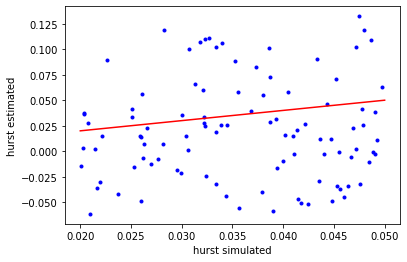

In [ ]:
plt.figure()
plt.plot(simulated, test, 'b.')
plt.plot([0.02, 0.05], [0.02, 0.05], 'r-')
# plt.plot([0.02, 0.05], [-0.08, -0.05], 'g-')
# plt.plot([0.02, 0.05], [0.02, 0.05], 'y-')
plt.xlabel('hurst simulated')
plt.ylabel('hurst estimated')
plt.show()

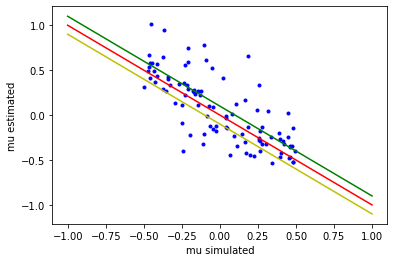

In [ ]:
plt.figure()
plt.plot(simulated, test, 'b.')
plt.plot([-1, 1], [1, -1], 'r-')
plt.plot([-1, 1], [1.1, -0.9], 'g-')
plt.plot([-1, 1], [0.9, -1.1], 'y-')
plt.xlabel('mu simulated')
plt.ylabel('mu estimated')
plt.show()

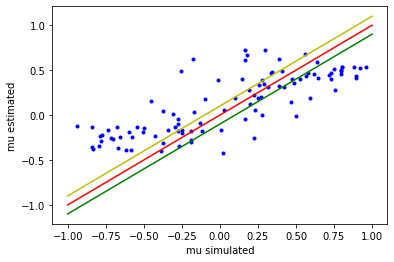

In [ ]:
plt.figure()
plt.plot(simulated, test, 'b.')
plt.plot([-1, 1], [-1, 1], 'r-')
plt.plot([-1, 1], [-1.1, 0.9], 'g-')
plt.plot([-1, 1], [-0.9, 1.1], 'y-')
plt.xlabel('mu simulated')
plt.ylabel('mu estimated')
plt.show()

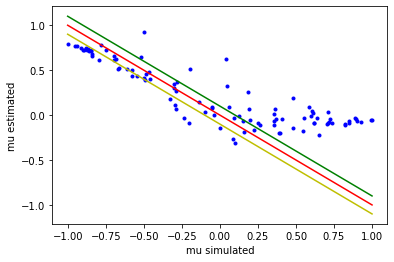

In [ ]:
plt.figure()
plt.plot(simulated, test, 'b.')
plt.plot([-1, 1], [1, -1], 'r-')
plt.plot([-1, 1], [1.1, -0.9], 'g-')
plt.plot([-1, 1], [0.9, -1.1], 'y-')
plt.xlabel('mu simulated')
plt.ylabel('mu estimated')
plt.show()

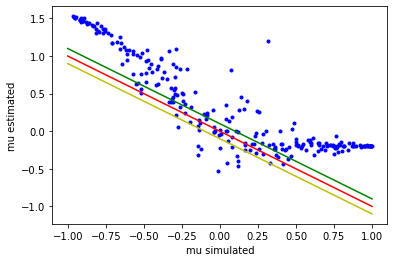

In [ ]:
plt.figure()
plt.plot(simulated, test, 'b.')
plt.plot([-1, 1], [1, -1], 'r-')
plt.plot([-1, 1], [1.1, -0.9], 'g-')
plt.plot([-1, 1], [0.9, -1.1], 'y-')
plt.xlabel('mu simulated')
plt.ylabel('mu estimated')
plt.show()

Keras convolutional model.

In [ ]:
nlength = 1500
t = 1
dt = t / nlength
hurst = 0.02

times = np.linspace(start=0, stop=t, num=nlength) # numpy.ndarray (nlength,)
paths = 100
m = 1

# # clear keras backend
K.clear_session()

# create keras backend
keras.backend.set_floatx('float64')

# convolution model
model = tf.keras.Sequential()
model.add(tf.keras.Input(batch_shape=(1, paths, nlength-1, 1)))
model.add(tf.keras.layers.Convolution2D(filters=1, kernel_size=1, activation=tf.keras.activations.elu))
model.add(tf.keras.layers.MaxPooling2D(pool_size=1))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(units=30, activation=tf.keras.activations.elu))
model.add(tf.keras.layers.Dense(units=1, activation=tf.keras.activations.elu))
model.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.mean_squared_error)

# sequential model
# model = keras.Sequential([
#     tf.keras.layers.Dense(30, activation=tf.keras.activations.elu, input_shape=(nlength-1,)),
#     tf.keras.layers.Dense(30, activation=tf.keras.activations.elu),
#     tf.keras.layers.Dense(1, activation=tf.keras.activations.elu),
# ])
# model.compile(optimizer='adam', loss=tf.keras.losses.mean_squared_error)
model.summary()

# generate fbm example
simulated = []
test = []

while len(test) != 100:
# for samples in tqdm(range(m)):
    fbm = FBM(n=nlength-1, hurst=hurst, length=t, method='cholesky')
    fbm_sample = [fbm.fbm() for i in range(paths)]

    W = np.array([fbm_sample]).reshape(nlength, paths)
    alpha = 10
    mu = np.random.uniform(0, 1)
    sigma = 0.3 #np.random.uniform(0, 1)

    sdepy_W = sdepy.process(t=times, x=W)

    @sdepy.integrate
    def X_process(t, x, alpha=1, mu=1, sigma=1):
        return {
            'dt': alpha*(mu - np.tanh(x)),
            'dw': sigma,
        }

    X = X_process(paths=paths, x0=0, alpha=alpha, mu=mu, sigma=sigma, dw=sdepy_W)(times)
    tanhX = np.tanh(X)
    x = np.transpose(pd.DataFrame(tanhX).values)
    xdiff = np.transpose(pd.DataFrame(tanhX).values[1:])
    
    for i in range(paths):
      for j in range(1, len(x)):
          xdiff[i, j-1] = tanhX[i, j]-tanhX[i, j-1]
    # # for convolution model model
    
    xdiff = xdiff[:, :, np.newaxis]
    xx = np.array(xdiff.reshape(1, paths, nlength-1, 1))
    estimated = model.predict(xx)
    simulated.append(mu)
    if np.linalg.norm(mu-estimated[0][0]) < 0.1:
      test.append(estimated[0][0])
    else:
      None
    print('simulated: ', mu, 'predicted: ', estimated)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (1, 100, 1499, 1)         2         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (1, 100, 1499, 1)         0         
_________________________________________________________________
flatten (Flatten)            (1, 149900)               0         
_________________________________________________________________
dense (Dense)                (1, 30)                   4497030   
_________________________________________________________________
dense_1 (Dense)              (1, 1)                    31        
Total params: 4,497,063
Trainable params: 4,497,063
Non-trainable params: 0
_________________________________________________________________
simulated:  0.2536795158136623 predicted:  [[-0.12800111]]
simulated:  0.8014161923728064 predicted:  [[-0.82364

KeyboardInterrupt: ignored

In [ ]:
plt.figure()
plt.plot(simulated, test, 'b.')
plt.plot([0, 1], [0, 1], 'r-')
plt.xlabel('sigma simulated')
plt.ylabel('sigma estimated')
plt.show()

Keras sequential model - autocorrelation pre-stat

In [ ]:
nlength = 3000
t = 1
dt = t / nlength
hurst = 0.02

times = np.linspace(start=0, stop=t, num=nlength) # numpy.ndarray (nlength,)
paths = 1
m = 1

# # clear keras backend
K.clear_session()

# create keras backend
keras.backend.set_floatx('float64')

model = keras.Sequential([
    # tf.keras.layers.Embedding(input_dim=nlength-1, output_dim=1),
    tf.keras.layers.Dense(30, activation='tanh', input_shape=(nlength,)),
    tf.keras.layers.Dense(40, activation='tanh'),
    tf.keras.layers.Dense(50, activation='tanh'),
    tf.keras.layers.Dense(1, activation='tanh'),
])
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

# generate fbm example
simulated = []
test = []

index = 0
append_index = 0

# while len(test) != 100:
for samples in tqdm(range(100)):
    index = index + 1
    fbm = FBM(n=nlength-1, hurst=hurst, length=t, method='cholesky')
    fbm_sample = fbm.fbm()

    W = fbm_sample.reshape(nlength, 1)
    alpha = 10
    mu = np.random.uniform(-0.5, 0.5)
    sigma = np.random.uniform(0, 1-np.abs(mu))

    sdepy_W = sdepy.process(t=times, x=W)

    @sdepy.integrate
    def X_process(t, x, alpha=1, mu=1, sigma=1):
        return {
            'dt': alpha*(mu - np.tanh(x)),
            'dw': sigma,
        }

    X = X_process(paths=1, x0=0, alpha=alpha, mu=mu, sigma=sigma, dw=sdepy_W)(times)
    tanhX = np.tanh(X)

    autocorrelation = np.correlate(tanhX.flatten(), tanhX.flatten(), mode='same')
    autocorrelation = autocorrelation.reshape(1, nlength)
    
    estimated = model.predict(autocorrelation)
    # # if np.linalg.norm(mu-estimated[0][0]) < 0.1:
    simulated.append(mu)
    test.append(estimated[0][0])
      # append_index = append_index + 1
      # print(f'appended: {append_index}')
    # else:
    #   None
    print(f'index: {index-1}','simulated: ', mu, 'predicted: ', estimated)









  0%|          | 0/100 [00:00<?, ?it/s]

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 30)                90030     
_________________________________________________________________
dense_1 (Dense)              (None, 40)                1240      
_________________________________________________________________
dense_2 (Dense)              (None, 50)                2050      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 51        
Total params: 93,371
Trainable params: 93,371
Non-trainable params: 0
_________________________________________________________________










  1%|          | 1/100 [00:07<13:10,  7.98s/it]

index: 0 simulated:  0.47150045351630665 predicted:  [[-0.24473231]]










  2%|▏         | 2/100 [00:15<13:01,  7.97s/it]

index: 1 simulated:  0.29330407679463155 predicted:  [[-0.22038163]]










  3%|▎         | 3/100 [00:23<12:50,  7.94s/it]

index: 2 simulated:  -0.3583784069007736 predicted:  [[-0.24473231]]


KeyboardInterrupt: ignored